In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame, Series
from dslabs_functions import select_redundant_variables, get_variable_types, encode_cyclic_variables, dummify, mvi_by_filling, evaluate_approach, plot_multibar_chart, determine_outlier_thresholds_for_var, set_chart_labels, study_variance_for_feature_selection, study_redundancy_for_feature_selection, HEIGHT, select_low_variance_variables
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from imblearn.over_sampling import SMOTE
from dslabs_functions import CLASS_EVAL_METRICS, DELTA_IMPROVE, read_train_test_from_files
from dslabs_functions import plot_evaluation_results, plot_multiline_chart
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from typing import Literal
from subprocess import call
from sklearn.tree import plot_tree

# Load split dataset

In [2]:
# Lire les données
train: DataFrame = read_csv("datasets/class_pos_covid_train.csv", index_col="Unnamed: 0", na_values=None)
test: DataFrame = read_csv("datasets/class_pos_covid_test.csv", index_col="Unnamed: 0", na_values=None)

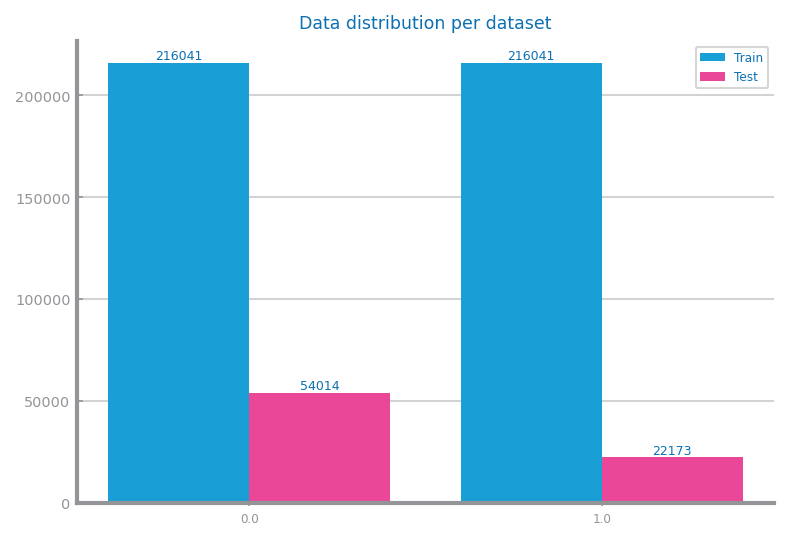

In [3]:
target = "CovidPos"

positive: int = 1
negative: int = 0
values: dict[str, list[int]] = {}

values["Train"] = [
    len(train[train[target] == negative]),
    len(train[train[target] == positive]),
]
values["Test"] = [
    len(test[test[target] == negative]),
    len(test[test[target] == positive]),
]

labels: list = list(train[target].unique())
labels.sort()

plt.figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
plt.show()

# Study

In [4]:
def trees_study(
        trnX: np.ndarray, trnY: np.array, tstX: np.ndarray, tstY: np.array, d_max: int=10, lag:int=2, metric='accuracy'
        ) -> tuple:
    criteria: list[Literal['entropy', 'gini']] = ['entropy', 'gini']
    depths: list[int] = [i for i in range(2, d_max+1, lag)]

    best_model: DecisionTreeClassifier | None = None
    best_params: dict = {'name': 'DT', 'metric': metric, 'params': ()}
    best_performance: float = 0.0

    values: dict = {}
    for c in criteria:
        y_tst_values: list[float] = []
        for d in depths:
            clf = DecisionTreeClassifier(max_depth=d, criterion=c, min_impurity_decrease=0)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval)
            if eval - best_performance > DELTA_IMPROVE:
                best_performance = eval
                best_params['params'] = (c, d)
                best_model = clf
            # print(f'DT {c} and d={d}')
        values[c] = y_tst_values
    print(f'DT best with {best_params["params"][0]} and d={best_params["params"][1]}')
    plot_multiline_chart(depths, values, title=f'DT Models ({metric})', xlabel='d', ylabel=metric, percentage=True)

    return best_model, best_params


def read_train_test_from_files_2(
    train_fn: str, test_fn: str, target: str = "class"
) -> tuple[np.ndarray, np.ndarray, np.array, np.array, list, list]:
    train: DataFrame = read_csv(train_fn, index_col="Unnamed: 0", na_values=None)
    labels: list = list(train[target].unique())
    labels.sort()
    trnY: np.array = train.pop(target).to_list()
    trnX: np.ndarray = train.values

    test: DataFrame = read_csv(test_fn, index_col="Unnamed: 0", na_values=None)
    tstY: np.array = test.pop(target).to_list()
    tstX: np.ndarray = test.values
    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()

Train#=432082 Test#=76187
Labels=[0.0, 1.0]
DT best with entropy and d=38


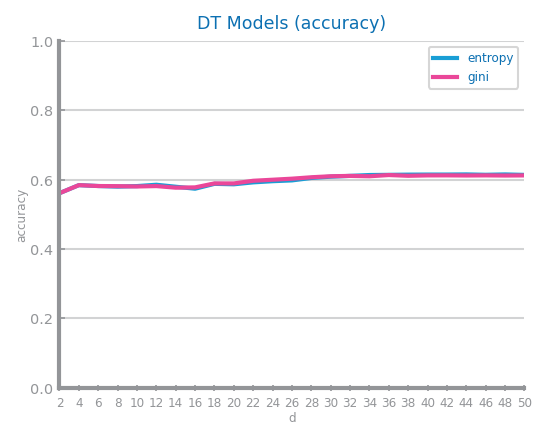

In [5]:
file_tag='class_pos_covid'
target = 'CovidPos'
eval_metric = 'accuracy'

trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files_2("datasets/class_pos_covid_train.csv", "datasets/class_pos_covid_test.csv", target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

plt.figure()
best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=50, metric=eval_metric)
plt.savefig(f'images/{file_tag}_dt_{eval_metric}_study.png')
plt.show()

<Figure size 600x450 with 0 Axes>

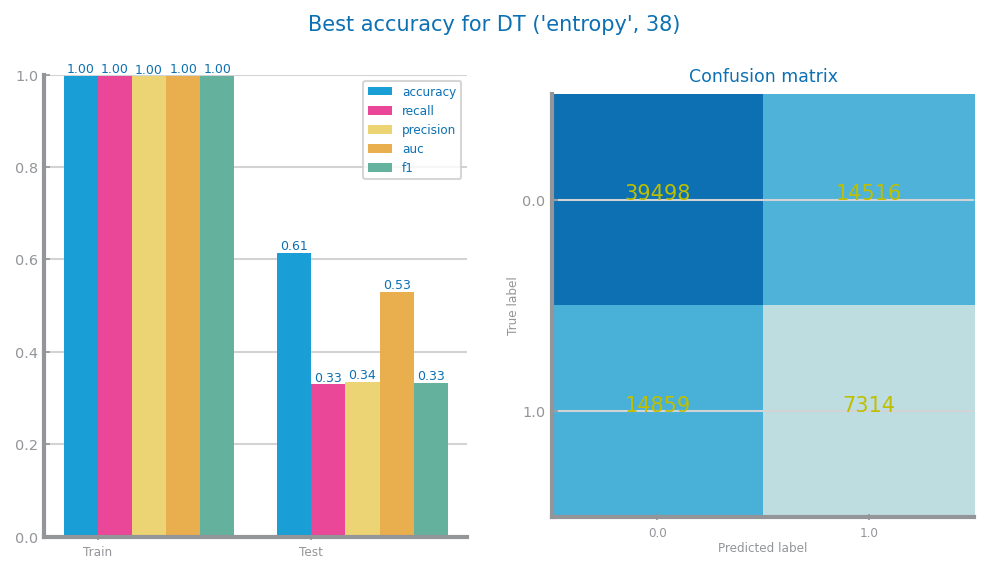

In [6]:
prd_trn: np.array = best_model.predict(trnX)
prd_tst: np.array = best_model.predict(tstX)
plt.figure()
plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
plt.savefig(f'images/{file_tag}_dt_{params["name"]}_best_{params["metric"]}_eval.png')
plt.show()

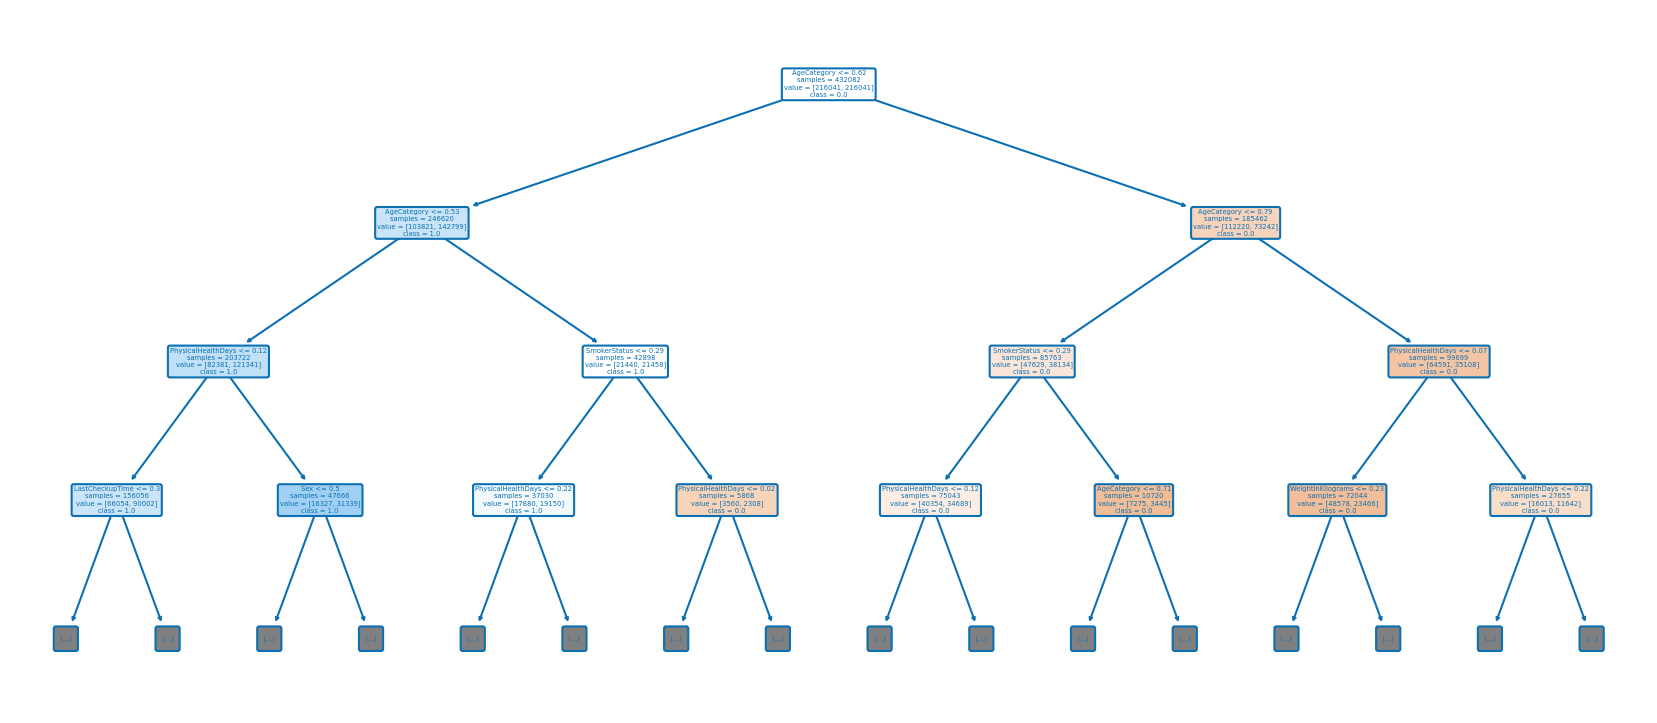

In [7]:

tree_filename: str = f"images/{file_tag}_dt_{eval_metric}_best_tree"
max_depth2show = 3
st_labels: list[str] = [str(value) for value in labels]
    

plt.figure(figsize=(14, 6))
plot_tree(
    best_model,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
plt.savefig(tree_filename + ".png")

1. BMI (0.13329298789184954)
2. State (0.1212040201151295)
3. WeightInKilograms (0.0938689540205864)
4. HeightInMeters (0.06737032339010961)
5. AgeCategory (0.05585048964243294)
6. MentalHealthDays (0.04517110450762849)
7. SleepHours (0.0430829786286696)
8. TetanusLast10Tdap (0.04139849811209355)
9. GeneralHealth (0.03933638159164867)
10. RemovedTeeth (0.03173905073110425)
11. PhysicalHealthDays (0.030857492314248045)
12. RaceEthnicityCategory (0.02791862085088218)
13. SmokerStatus (0.022927056971616275)
14. ECigaretteUsage (0.020050345165618946)
15. LastCheckupTime (0.016838313980611235)
16. HIVTesting (0.014898632795545968)
17. PhysicalActivities (0.013793608078816627)
18. PneumoVaxEver (0.013733032310140504)
19. HadDiabetes (0.01362600243064837)
20. AlcoholDrinkers (0.013373193425787931)
21. HadArthritis (0.013365165121766906)
22. HadDepressiveDisorder (0.012626688729955012)
23. HadAsthma (0.012047996002407366)
24. FluVaxLast12 (0.0118289508457534)
25. DifficultyConcentrating (0.008

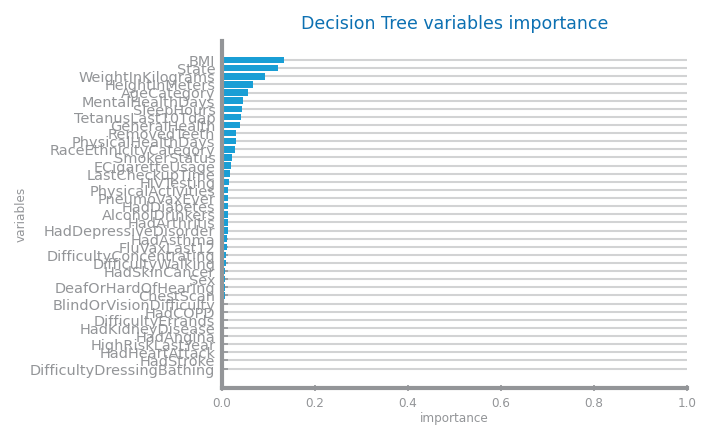

In [8]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

plt.figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title="Decision Tree variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
plt.savefig(f"images/{file_tag}_dt_{eval_metric}_vars_ranking.png")

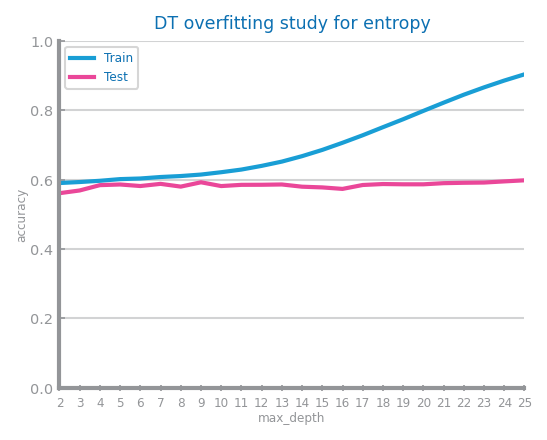

In [9]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: np.array = clf.predict(tstX)
    prd_trn_Y: np.array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

plt.figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
plt.savefig(f"images/{file_tag}_dt_{eval_metric}_overfitting.png")